In [2]:
import os
import numpy as np
import dask.array as da
from dask.distributed import Client
from functions import kernel_est_funcs as kef
from functions import conn_inf_funcs as cif 
from functions import remove_outliers as ro

import matplotlib.pyplot as plt
import h5py

In [3]:
hdf5_path = '/home/mjoudy/Documents/spikes-2.h5'

In [4]:
# Open your HDF5 file to inspect its structure
with h5py.File(hdf5_path, 'r') as hdf_file:
    # List all datasets or groups in the file
    print("Contents of the file:")
    for key in hdf_file.keys():
        print(key)

Contents of the file:
spikes-ds


In [5]:
hdf5_file = h5py.File(hdf5_path, 'r')

# Access the dataset you want to work with (replace 'your_dataset' with the actual dataset name)
hdf5_dataset = hdf5_file['spikes-ds']
hdf5_dataset.shape
hdf_test = hdf5_dataset[:, 0:100000]

In [8]:
gr = np.load('data/connectivity-10e4-ms.npy')

In [11]:
gr.shape

(1250, 1250)

In [10]:
client  = Client()

dask_array = da.from_array(hdf_test, chunks=('auto', 100000))
pr1 = dask_array.map_blocks(kef.dask_calcium, dtype=dask_array.dtype)
pr2 = pr1.map_blocks(kef.dask_smooth, dtype=dask_array.dtype)
pr3 = pr2.map_blocks(cif.conn_inf_LR(gr, pr2), dtype=dask_array.dtype)
result = pr2.compute()

/home/mjoudy/miniconda3/envs/phd_conda/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46225 instead
  warnings.warn(


TypeError: expected str, bytes or os.PathLike object, not ndarray

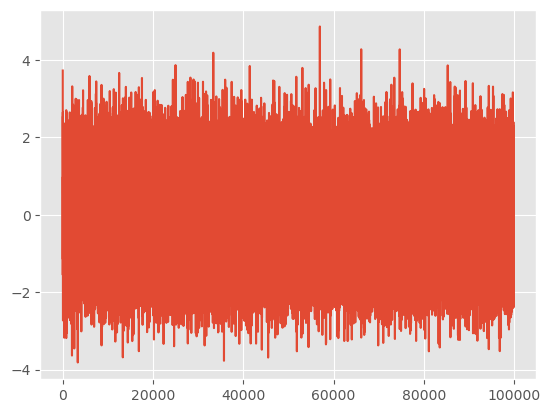

In [6]:
plt.plot(result[500, :])

In [4]:
# Set up a Dask client for parallelism
client = Client()

# Open the HDF5 file and get the unnamed/default dataset
with h5py.File(hdf5_path, 'r') as hdf_file:
    # Access the first (and likely only) dataset in the file
    dset = list(hdf_file.values())[0]  # Automatically grab the first dataset

    print("Dataset shape:", dset.shape)

    # Create a Dask array from the HDF5 dataset, defining the chunk size
    dask_array = da.from_array(dset, chunks=(1250, 100))  # Adjust chunk size as needed

    # Apply the first function using map_blocks
    pr1 = dask_array.map_blocks(kef.dask_calcium, dtype=dask_array.dtype)

    # Apply the second function on the result of the first
    pr2 = pr1.map_blocks(kef.dask_smooth, dtype=dask_array.dtype)

    # Compute the result
    result = pr2.compute()

# Check the result
print("Processing completed!")

/home/mjoudy/miniconda3/envs/phd_conda/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45521 instead
  warnings.warn(


Dataset shape: (1250, 1000)


2024-10-16 16:17:42,428 - distributed.worker - ERROR - Compute Failed
Key:       ('dask_smooth-ab2c89773ce76933dae7e34a5e5c2740', 0, 9)
State:     executing
Function:  subgraph_callable-cdf5b757c285362a43f1762de8700516
args:      (<HDF5 dataset "dataset_name": shape (1250, 1000), type "<f8">, (slice(0, 1250, None), slice(900, 1000, None)))
kwargs:    {}
Exception: "IndexError('index 0 is out of bounds for axis 1 with size 0')"
Traceback: '  File "/home/mjoudy/miniconda3/envs/phd_conda/lib/python3.12/site-packages/dask/optimization.py", line 1028, in __call__\n    return core.get(self.dsk, self.outkey, dict(zip(self.inkeys, args)))\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/home/mjoudy/miniconda3/envs/phd_conda/lib/python3.12/site-packages/dask/core.py", line 163, in get\n    result = _execute_task(task, cache)\n             ^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/home/mjoudy/miniconda3/envs/phd_conda/lib/python3.12/site-packages/dask/core.py", line

IndexError: index 0 is out of bounds for axis 1 with size 0

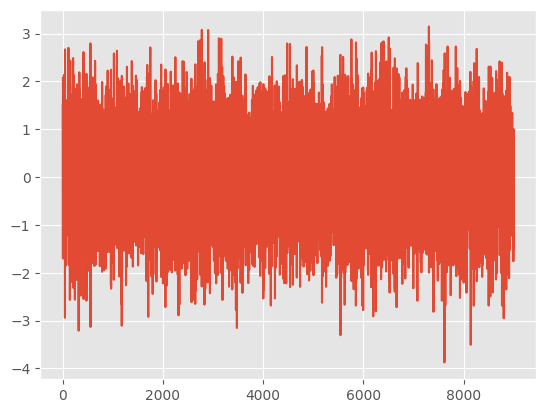

In [8]:
plt.plot(result[500])

In [ ]:
client = Client()
# Define Process 1
def process_1(block):
    print(f"Process 1 running on chunk with shape {block.shape}")
    return block * 2

# Define Process 2
def process_2(block):
    print(f"Process 2 running on chunk with shape {block.shape}")
    return block + 5

# Create a large Dask array with chunks
large_array = da.random.random((1000, 100000), chunks=(20, 10000))

# Apply Process 1 using map_blocks
processed_1 = large_array.map_blocks(process_1)

# Apply Process 2 using map_blocks on the result of Process 1
processed_2 = processed_1.map_blocks(process_2)

# Trigger computation and track progress
result = processed_2.compute()
print("Processing completed!")